In [62]:
import json
import os
import sys
import csv
import shutil
import cv2
import pandas as pd
import matplotlib.pyplot as plt

### Take all the train and test data files into a new folder and rename in ascending order




In [4]:
test_folder1 = r"D:\FYP Datasets\BAGLS\test\test" #folder containing the images
test_folder2 = r"D:\FYP Datasets\BAGLS\test\annotations" #folder containing the annotations

train_folder1 = r"D:\FYP Datasets\BAGLS\training\training" 
train_folder2 = r"D:\FYP Datasets\BAGLS\training\annotations"

output_folder1 = r"D:\FYP Datasets\fypBAGLS\raw\Data"
output_folder2 = r"D:\FYP Datasets\fypBAGLS\raw\Annotations"


In [6]:
#copying train images and annotations
for filename in os.listdir(train_folder1):
    shutil.copy2(os.path.join(train_folder1, filename), output_folder1)

for filename in os.listdir(train_folder2):
    shutil.copy2(os.path.join(train_folder2, filename), output_folder2)

In [14]:
#find number of images in the current output folder

lastnum = 0
checker = 0
for file in os.listdir(output_folder1):
    if file.endswith(".meta"):
        lastnum += 1
for file in os.listdir(output_folder2):
    if file.endswith(".txt"):
        checker += 1

print("Number of images in the output folder: ", lastnum)
print("Number of annotations in the output folder: ", checker)

Number of images in the output folder:  55750
Number of annotations in the output folder:  52229


In [ ]:
#copying test images and annotations and rename starting from the last number
counter1,counter2,counter3 = lastnum, lastnum, lastnum

for filename in os.listdir(test_folder1):
    if filename.endswith("_seg.png"):
        shutil.copy2(os.path.join(test_folder1, filename), os.path.join(output_folder1, str(counter1)+"_seg.png"))
        counter1 += 1
    elif filename.endswith(".meta"):
        shutil.copy2(os.path.join(test_folder1, filename), os.path.join(output_folder1, str(counter2)+".meta"))
        counter2 += 1
    elif filename.endswith(".png") and not filename.endswith("_seg.png"):
        shutil.copy2(os.path.join(test_folder1, filename), os.path.join(output_folder1, str(counter3)+".png"))
        counter3 += 1

for filename in os.listdir(test_folder2):
    f = int(filename.split(".")[0])
    shutil.copy2(os.path.join(test_folder2, filename), os.path.join(output_folder2, str(f+lastnum)+".txt"))

print("Number of images in the output folder: ", counter1,counter2,counter3)

Number of images in the output folder:  55750 55750 55750


In [23]:
# find total number of images in the output folder
img_count = 0
anno_count = 0
for file in os.listdir(output_folder1):
    if file.endswith(".meta"):
        img_count += 1
print("Total number of images in the output folder: ", img_count)
for file in os.listdir(output_folder2):
    if file.endswith(".txt"):
        anno_count += 1
print("Total number of annotations in the output folder: ", anno_count)

Total number of images in the output folder:  59250
Total number of annotations in the output folder:  55286


## Finds the bounding boxes all files 

*omitted since annotations already included but put here fore reference*
*and stores in a .txt file (annotation of YOLOv8)*

```python

In [ ]:
input_folder = r"D:\FYP Datasets\BAGLS\training\training"
output_folder = r"D:\FYP Datasets\BAGLS\training_bb"

In [ ]:
def detect_bounding_boxes(img):
    x_min, y_min, x_max, y_max = float('inf'), float('inf'), 0, 0
    cntrs, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in cntrs:
        x, y, w, h = cv2.boundingRect(c)
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x + w)
        y_max = max(y_max, y + h)
    #convert to yolo
    x_center = (x_min + x_max) / 2 / img.shape[1]
    y_center = (y_min + y_max) / 2 / img.shape[0]
    width = (x_max - x_min) / img.shape[1]
    height = (y_max - y_min) / img.shape[0]
    return x_center, y_center, width, height



In [ ]:
for file in os.listdir(input_folder):
    if file.endswith("_seg.png"):
        img = cv2.imread(os.path.join(input_folder, file), cv2.IMREAD_GRAYSCALE)
        x, y, w, h = detect_bounding_boxes(img)
        if x == float('inf') or y == float('inf'):
            continue
        #write in a new text file and save in another folder
        with open(os.path.join(output_folder, file.replace("_seg.png", ".txt")), "w") as f: #replace _seg.png with .txt to follow 
            f.write(f"3 {x} {y} {w} {h}")

##  EDA

*parse and create metadata with the .meta files first FOR FRAMES*

In [31]:
input_folder = r"D:\FYP Datasets\fypBAGLS\raw\Data"
check_folder = r"D:\FYP Datasets\fypBAGLS\raw\Annotations"
output_folder = r"D:\FYP Datasets\fypBAGLS\raw"
meta_file = r"D:\FYP Datasets\fypBAGLS\raw\Data\0.meta"

In [ ]:
#creating csv file and header
#additional header for "open" and "close" for the bounding box
with open(meta_file, 'r') as f:
    data = json.load(f)
    headers = data.keys()
    headers = list(headers)
    headers.append('glottis status')
    headers.insert(0, 'Filename')
    with open(output_folder + "/metadata.csv" , 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)

In [29]:
#append data into csvfile and parse metadata
with open(os.path.join(output_folder, 'metadata.csv'), 'a', newline='') as f:
    writer = csv.writer(f)
    for filename in os.listdir(input_folder):
        if filename.endswith(".meta"):
            name = filename.split(".")[0]
            with open(os.path.join(input_folder, filename), 'r') as file:
                data = json.load(file)
                relevant_data = [name]
                for key in data.keys():
                    relevant_data.append(data[key])
                writer.writerow(relevant_data)

*update the status of the frame if the glottis is open or close*

In [57]:
#cross check number w annotations if the image has a bounding box and update the csv file in status column
a = 0
df = pd.read_csv(output_folder + "/metadata.csv")
df['status'] = 'close' #default status
#update first row

for file in os.listdir(check_folder):
    if file.endswith(".txt"):
        name = int(file.split(".")[0])
        df.loc[name, 'status'] = 'open' 
        a += 1

df.to_csv(output_folder + "/metadata.csv", index=False) #save the updated csv file
print("Number of images with annotations: ", a)
                    

Number of images with annotations:  55286


*Data analysis and visualization*

In [59]:
#find proportion of images with bounding boxes per video and plot
df = pd.read_csv(output_folder + "/metadata.csv")

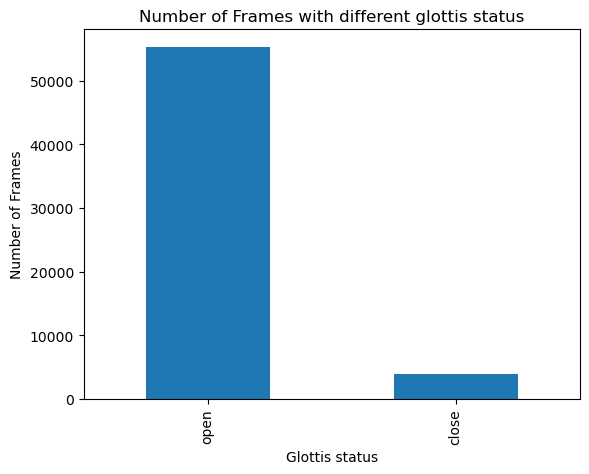

In [61]:
#number of frames with bounding boxes
df['glottis status'].value_counts().plot(kind='bar')
plt.title("Number of Frames with different glottis status")
plt.xlabel("Glottis status")
plt.ylabel("Number of Frames")
plt.show()


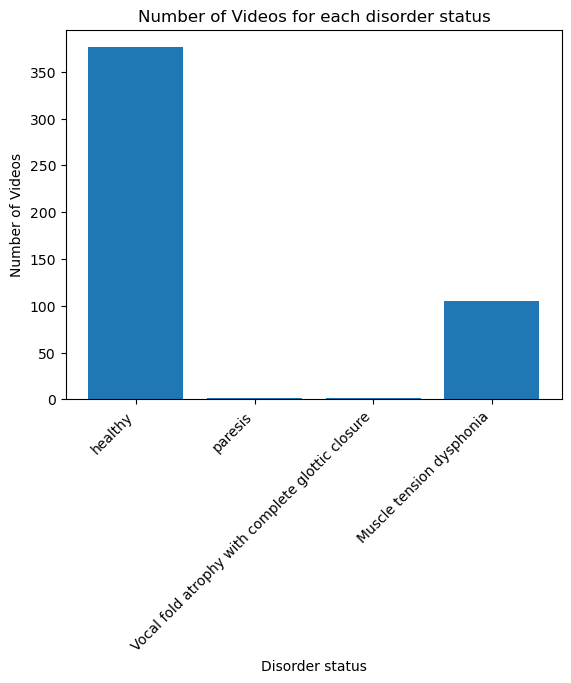

Number of videos with healthy status:  376
Number of videos with paresis status:  2
Number of videos with Vocal fold atrophy with complete glottic closure status:  1
Number of videos with Muscle tension dysphonia status:  105


In [81]:
#plot number of videos with healthy, paresis, vocal fold atrophy with complete glottic closure and muscle tension dysphoniat
# Count the number of videos for each disorder status
categories = ["healthy", "paresis", "Vocal fold atrophy with complete glottic closure", "Muscle tension dysphonia"]
counts = [len(set(df[df["Subject disorder status"] == cat]["Video Id"])) for cat in categories]

# Plot the number of videos for each disorder status
plt.bar(categories, counts)
plt.title("Number of Videos for each disorder status")
plt.xlabel("Disorder status")
plt.ylabel("Number of Videos")
# Rotate x-axis labels for readability (90 degrees to avoid overlap)
plt.xticks(rotation=45, ha='right')  # Rotate by 45 degrees for better fit
# plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

print("Number of videos with healthy status: ", counts[0])
print("Number of videos with paresis status: ", counts[1])
print("Number of videos with Vocal fold atrophy with complete glottic closure status: ", counts[2])
print("Number of videos with Muscle tension dysphonia status: ", counts[3])


In [88]:
#plot videos with all closed glottis

# Count the number of videos with all open glottis
videos = df["Video Id"].unique()
closed_glottis_videos = []
for video in videos:
    video_df = df[df["Video Id"] == video]
    if all(video_df["glottis status"] == "close"):
        closed_glottis_videos.append(video)
        
print("Number of videos with all closed glottis: ", len(closed_glottis_videos))

Number of videos with all closed glottis:  0


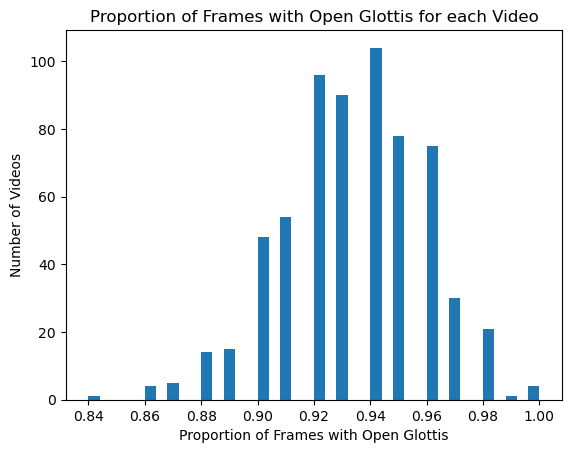

Video ID:  566 Proportion:  0.84


In [98]:
#find proportion of frames per video that is opened

# Calculate the proportion of frames with open glottis for each video
proportions = []
# print(len(df["Video Id"].unique()))
for video in range(len(df["Video Id"].unique())):
    video_df = df[df["Video Id"] == video]
    proportions.append(len(video_df[video_df["glottis status"] == "open"]) / len(video_df))
    
# Plot the proportion of frames with open glottis for each video
plt.hist(proportions, bins=40)
plt.title("Proportion of Frames with Open Glottis for each Video")
plt.xlabel("Proportion of Frames with Open Glottis")
plt.ylabel("Number of Videos")
plt.show()

#print the video id of those below 0.90
for i in range(len(proportions)):
    if proportions[i] < 0.85:
        print("Video ID: ", i, "Proportion: ", proportions[i])
    